# Optimize Season Points
 - Assume every player will perform and do exactly the same as last year
 - yup... very strong assumption
 - Cost of 11 players must be below £100
 - Only 1 GK
 - 3 to 5 DEF
 - 3 to 5 MID
 - 1 to 3 STR
 - Captain gets X2 points
 - Player with most points is captain throughout the whole year

In [1]:
import pandas as pd
import numpy as np
from scipy.optimize import minimize
import matplotlib.pyplot as plt
import matplotlib.style as style
import seaborn as sns

sns.set()
style.use('fivethirtyeight')
%matplotlib inline

In [2]:
data = pd.read_csv("data/clean-data.csv")

In [3]:
N = data.shape[0]
POINTS = np.array(data.Points)
CALC_POINTS = np.array(data['Calc Points'])
COST = np.array(data.Cost)
POSITION = np.array(data.Position)

In [4]:
def random_walk(n):
    return np.random.rand(11) * n

def to_int(x):
    return (x - 0.5).astype(int)

def objective(x):
    x_int = to_int(x)
    points11 = POINTS[x_int]
    return -(points11.sum() + points11.max())

def objective_calc(x):
    x_int = to_int(x)
    points11 = CALC_POINTS[x_int]
    return -(points11.sum() + points11.max())

def constraint_cost(x):
    # Cost is less than £100
    # -(sum(cost) - 100) >= 0
    x_int = to_int(x)
    return -(COST[x_int].sum() - 100.0)

def constraint_gk(x):
    # Only 1 GK
    # count('GK') - 1 = 0
    x_int = to_int(x)
    return (POSITION[x_int] == 'GK').sum() - 1
    
def constraint_def_3(x):
    # 3to5 DEF
    # count('DEF') - 3 >= 0 
    x_int = to_int(x)
    return (POSITION[x_int] == 'DEF').sum() - 3

def constraint_def_5(x):
    # 3to5 DEF
    # -(count('DEF') - 5) >= 0 
    x_int = to_int(x)
    return -((POSITION[x_int] == 'DEF').sum() - 5)

def constraint_mid_3(x):
    # 3to5 MID
    # count('MID') - 3 >= 0 
    x_int = to_int(x)
    return (POSITION[x_int] == 'MID').sum() - 3

def constraint_mid_5(x):
    # 3to5 MID
    # -(count('MID') - 5) >= 0 
    x_int = to_int(x)
    return -((POSITION[x_int] == 'MID').sum() - 5)

def constraint_str_1(x):
    # 1to3 STR
    # count('STR') - 1 >= 0 
    x_int = to_int(x)
    return (POSITION[x_int] == 'STR').sum() - 1

def constraint_str_3(x):
    # 1to3 STR
    # -(count('STR') - 3) >= 0 
    x_int = to_int(x)
    return -((POSITION[x_int] == 'STR').sum() - 3)

def constraint_all(x):
    test = [constraint_cost(x) >= 0,
            constraint_gk(x) == 0,
            constraint_def_3(x) >= 0,
            constraint_def_5(x) >= 0,
            constraint_mid_3(x) >= 0,
            constraint_mid_5(x) >= 0,
            constraint_str_1(x) >= 0,
            constraint_str_3(x) >= 0]
    return(all(test))

## Optimization Strategy 1
 - Randomly pick 11 players in the lineup
 - Repeat 10,000 times
 - Filter lineup with correct constraints
 - Pick lineup with max points

In [5]:
np.random.seed(0)
lineup = []
total_points = []
constraint_test = []
for i in range(10000):
    x = random_walk(N)
    lineup.append(x)
    total_points.append(-objective(x))
    constraint_test.append(constraint_all(x))

In [36]:
trial_data = pd.DataFrame()
trial_data['Lineup'] = lineup
trial_data['Points'] = total_points
trial_data['Constraints'] = constraint_test
trial_data = (trial_data
              .sort_values('Points', ascending=True)
              .reset_index(drop=True))
trial_data['Trials'] = range(10000)

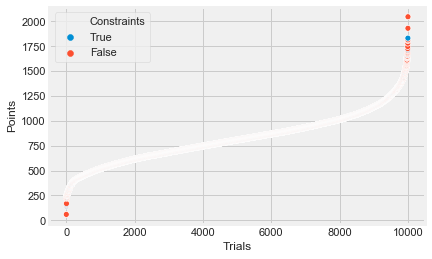

In [37]:
cmap = sns.cubehelix_palette(rot=-.2, as_cmap=True)
ax = sns.scatterplot(x="Trials", y="Points",
                     hue="Constraints",
                     hue_order=[True, False],
                     data=trial_data)

In [49]:
max_index = (trial_data
             .query('Constraints')
             ['Points']
             .idxmax())
player_index = to_int(trial_data.Lineup[max_index])

In [50]:
FINAL_POINTS = trial_data.iloc[max_index, 1]
PASS_CONSTRAINTS = trial_data.iloc[max_index, 2]
FINAL_XI = (data
            .iloc[player_index,:]
            [['Player', 'Position', 'Cost', 'Points']]
            .sort_values("Position")
            .reset_index(drop=True))
FINAL_COST = FINAL_XI['Cost'].sum()

In [54]:
print(("Spend £{} for expected total points {} "
      + "and passed all constraints {}")
      .format(FINAL_COST, FINAL_POINTS, PASS_CONSTRAINTS))
FINAL_XI

Spend £97.7 for expected total points 1831.0 and passed all constraints True


,Player,Position,Cost,Points
0,"LOVREN, D",DEF,8.7,151.0
1,"BERTRAND, R",DEF,8.2,117.0
2,DANILO,DEF,8.4,126.0
3,"SHAW, L",DEF,7.8,55.0
4,"MORAES, E",GK,7.9,188.0
5,"DAVIES, T",MID,7.6,72.0
6,"BRADY, R",MID,7.3,51.0
7,"PRITCHARD, A",MID,7.3,42.0
8,"FIRMINO, R",STR,12.2,193.0
9,"AUSTIN, C",STR,9.4,80.0
